# Поиск фото "Со смыслом"

Мы работаетем в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”).

Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т.д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.

Наш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Сервис выводит несколько фотографий с такой же или похожей сценой.

Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.
На основе лучшей модели можно будет собрать предварительную версию продукта, которую вы покажете руководителю компании.

### Юридические ограничения

В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

В нашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

    This image is unavailable in your country in compliance with local laws.
    
Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер.

### Описание данных

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберем либо одну из них, либо объединим их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Наша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

Для того, чтобы нейросети обучались быстрее, нам нужно выполнять вычисления в облачных сервисах. Поэтому дааные загрузим с сервера Яндекс, чтобы все папки скачались на виртуальные

In [ ]:
!wget -N https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -uq dsplus_integrated_project_4.zip
!ls

--2023-10-19 13:40:40--  https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150987455 (144M) [application/zip]
Saving to: ‘dsplus_integrated_project_4.zip’

dsplus_integrated_p 100%[===================>] 143.99M  6.46MB/s    in 20s     

2023-10-19 13:41:01 (7.10 MB/s) - ‘dsplus_integrated_project_4.zip’ saved [150987455/150987455]

dsplus_integrated_project_4.zip  __MACOSX  sample_data	to_upload


Установим дополнительные библиотеки Keras-NLP и Sentence-Transformers.

In [ ]:
!pip install -q --upgrade keras-nlp tensorflow
!pip install -q sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.1/590.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.4 MB/s eta 0:0

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import nltk
import re
from nltk.corpus import stopwords
import os

from PIL import Image

#импортируем библиотеки для архитектуры нейронных сетей
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import tensorflow as tf
import keras_nlp

from tqdm import notebook

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import sentence_transformers
from sentence_transformers import SentenceTransformer, util
from transformers import BertTokenizer
import torch
from torchvision import transforms
import glob

Using TensorFlow backend


In [ ]:
#загрузим необходимые модули для работы nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
direct = r'/content/to_upload'
RANDOM_STATE = 12345

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [ ]:
train_data = pd.read_csv(os.path.join(direct, 'train_dataset.csv'))
train_data.name = 'train_data'
data_crowd = pd.read_csv(os.path.join(direct, 'CrowdAnnotations.tsv'), sep='\t', names = ['image', 'query_id', 'fraction', 'pros', 'cons'])
data_crowd.name = 'data_crowd'
data_expert = pd.read_csv(os.path.join(direct, 'ExpertAnnotations.tsv'), sep='\t', names = ['image', 'query_id', 'first', 'second', 'third'])
data_expert.name = 'data_expert'
test_query = pd.read_csv(os.path.join(direct, 'test_queries.csv'), index_col=[0], sep='|')
test_query.name = 'test_query'
test_image = pd.read_csv(os.path.join(direct, 'test_images.csv'))
test_image.name = 'test_image'

In [ ]:
for dataframe in [train_data, data_crowd, data_expert, test_query, test_image]:
    print('------------------------------------------------------------------------------------------------------------')
    print(dataframe.name)
    display(dataframe.head())
    print(dataframe.shape)
    print()

------------------------------------------------------------------------------------------------------------
train_data


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

(5822, 3)

------------------------------------------------------------------------------------------------------------
data_crowd


image                     query_id  fraction  pros  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2       1.0     3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2       0.0     0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2       0.0     0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2       0.0     0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2       0.0     0   

   cons  
0     0  
1     3  
2     3  
3     3  
4     3

(47830, 5)

------------------------------------------------------------------------------------------------------------
data_expert


image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  
0      1  
1      2  
2      2  
3      2  
4      2

(5822, 5)

------------------------------------------------------------------------------------------------------------
test_query


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

(500, 3)

------------------------------------------------------------------------------------------------------------
test_image


image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

(100, 1)



In [ ]:
print('Количество уникальных фото на трейне:', len(train_data['image'].unique()))
print('Количество уникальных фото на тесте:', len(test_query['image'].unique()))

Количество уникальных фото на трейне: 1000
Количество уникальных фото на тесте: 100


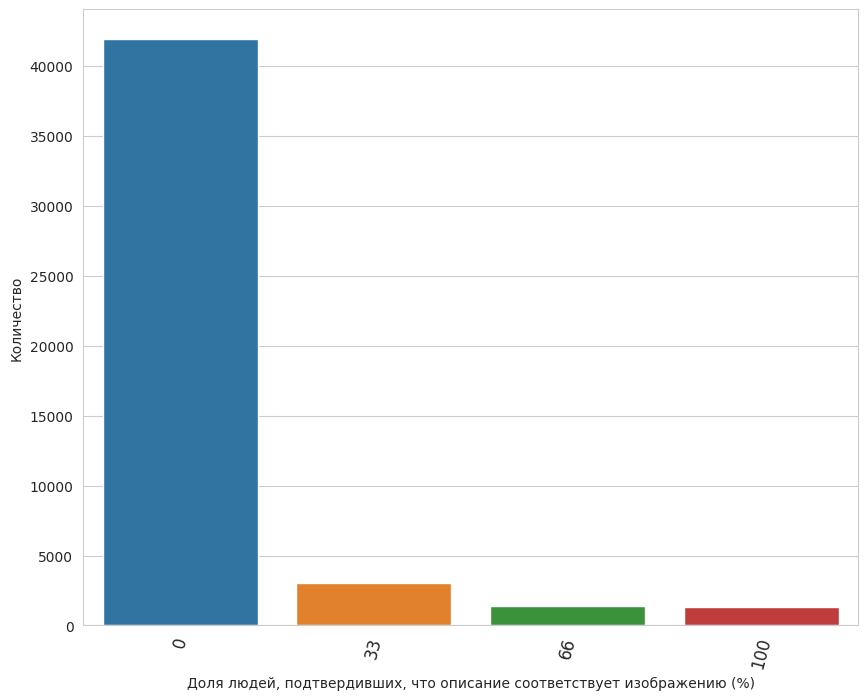

In [ ]:
crowd_analicit = data_crowd.copy()
crowd_analicit['fraction'] *= 100
crowd_analicit['fraction'] = crowd_analicit['fraction'].astype('int')
crowd_array=[]
fraction_nums = np.array([0, 33, 66, 100])
for i in fraction_nums:
    crowd_array.append((crowd_analicit['fraction'] == i).sum())

sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
sns.barplot(x = fraction_nums, y = crowd_array)
plt.xticks(rotation=75, size=12)
plt.xlabel('Доля людей, подтвердивших, что описание соответствует изображению (%)')
plt.ylabel('Количество')
plt.show()

Познакомимся с изображениями, входящими в датасеты.

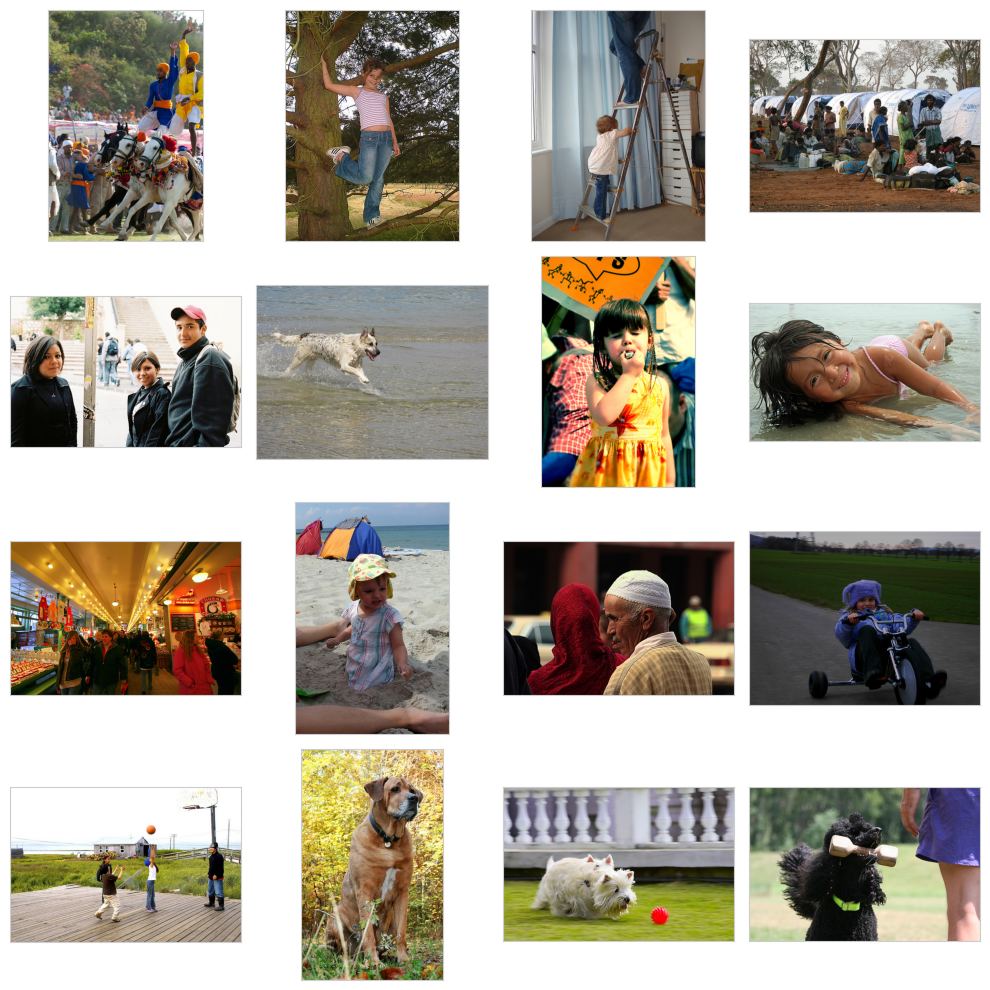

In [ ]:
samples_train = list(train_data['image'].sample(8))
samples_test = list(test_query['image'].sample(8))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(direct, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image = Image.open(Path(direct, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Выводы

У нас есть 5 датасетов:

- Данные тренировочной и тестовой выборок
- Оценки от экспертов и людей
- Папки с данными для тренировки и теста

Поскольку в данных содержатся сслыки на файлы в папке, то есть названия этих изображений, то в нейронные сети будем загружать данные из таблиц и она будет брать файлы из папок. Мы указали путь к папке, где все лежит и поместили его в переменную.

Сами же изображения все цветные, разных ракурсов. Они показывают как людей, так и животных. Далее нам надо будет их обработать и оставить только нужные.

## Агрегация
Нам нужно агрегировать оценки чтобы превратить их в целевую переменную. Сначала усредним и соберм оценки экспертов, потом объединим их с пользователями.

In [ ]:
def expert_aggregate(row) -> object:

    '''поискав способы агрегации построим такой алгоритм, который будет агрегировать оценки'''

    if row['first'] != row['second'] != row['third']:
        row['expert_score'] = (row['first'] + row['second'] + row['third'] - 3) / 3 / 3

    else:
        row['expert_score'] = (max(set([row['first'], row['second'], row['third']]), key = [row['first'], row['second'], row['third']].count) - 1) / 3

    return row

data_expert = data_expert.apply(expert_aggregate, axis=1)

In [ ]:
scores_data = pd.merge(data_expert, data_crowd, how='outer', on=['image', 'query_id'])

In [ ]:
def score_aggregate(row) -> object:

    '''аггрегируем оценки людей и экспертов'''

    if np.isnan(row['expert_score']):
        row['score'] = row['fraction']
    elif np.isnan(row['fraction']):
        row['score'] = row['expert_score']
    else:
        row['score'] = row['expert_score'] * 0.7 + row['fraction'] * 0.3

    return row

scores_data = scores_data.apply(score_aggregate, axis=1)

In [ ]:
display(scores_data.head())

image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2    1.0     1.0   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2    1.0     1.0   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2    1.0     1.0   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2    1.0     2.0   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2    1.0     1.0   

   third  expert_score  fraction  pros  cons     score  
0    1.0      0.000000       0.0   0.0   3.0  0.000000  
1    2.0      0.000000       0.0   0.0   3.0  0.000000  
2    2.0      0.000000       NaN   NaN   NaN  0.000000  
3    2.0      0.333333       NaN   NaN   NaN  0.333333  
4    2.0      0.000000       NaN   NaN   NaN  0.000000

In [ ]:
train_data = pd.merge(train_data, scores_data[['image', 'query_id', 'score']], how='outer', on=['image', 'query_id'])

Далее нам нужно заполнить пропуски. Поскольку данных уникальных не так много, то идентификаторы должны совпадать. ПОэтому нам надо сначала образовать датасет со всеми заполненными значениями.

Потом нужна функция, которая пройдется по идентификаторам и вставит текст туда, если идентификатор совпадает.

In [ ]:
to_fill = train_data[train_data['query_text'].notna()]

In [ ]:
def fill_text(row) -> object:

    if pd.isnull(row['query_text']):
        texts = to_fill[to_fill['query_id'] == row['query_id']]['query_text']
        if len(texts) > 0:
            row['query_text'] = texts.iloc[0]

    return row

train_data = train_data.apply(fill_text, axis=1)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


После добавления все равно остались пропуски.

In [ ]:
train_data.dropna(inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


### Выводы

Оценки аггрегированы, столбец для целевой переменной подготовлен.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [ ]:
disclaimer_words = ['teenage', 'baby', 'child', 'teenager', 'girl', 'boy', 'kid']

In [ ]:
lemmatize = nltk.WordNetLemmatizer()

def get_lemmas(text):

    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    text = nltk.word_tokenize(text, language = 'english')
    text = [lemmatize.lemmatize(word) for word in text]

    return text

def cleaning(row):

    text = get_lemmas(row['query_text'])
    if [i for i in text if i in disclaimer_words]:
        row['to_block'] = 1
    else:
        row['to_block'] = 0

    return row

In [ ]:
train_data = train_data.apply(cleaning, axis=1)

In [ ]:
print(train_data[train_data['to_block'] == 1]['query_text'].sample(10).unique())

['Two girls and a woman walking on the sidewalk'
 'A girl goes down a blue and yellow slide at a park .'
 'A young girl is wearing a purple shirt and pink headband .'
 'A boy in swim trunks screams while being sprayed with water .'
 'A smiling boy in an orange shirt with a safari hat sits at the playground , while a boy in a blue shirt looks on .'
 'A girl wearing shorts plays jump rope .' 'Two children look up .'
 'a boy plays with a noodle by the pool .'
 'Some kids play outside on a nice day .'
 'Two smiling little girls playing in a fountain with other people .']


In [ ]:
train_data.drop(train_data[train_data['to_block'] == 1].index, inplace=True, errors='ignore')
train_data.drop(columns='to_block', inplace=True, errors='ignore')
train_data.reset_index(inplace=True, drop=True)

In [ ]:
display(train_data.head(), test_query.head())

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
1  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
2   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
3   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
4   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                        query_text     score  
0  A man sleeps under a blanket on a city street .  0.000000  
1  A man sleeps under a blanket on a city street .  0.333333  
2  A man sleeps under a blanket on a city street .  0.233333  
3  A man sleeps under a blanket on a city street .  0.333333  
4  A man sleeps under a blanket on a city street .  0.000000

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

### Выводы

Данные избавлены от запрещенного контента. Теперь приступаем к подготовки материала.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [ ]:
def load_train(path=direct):
    '''Применим аугментацию и создадим выборку'''

    norm = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        norm,
    ])

    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=Path(path, 'train_images'),
        x_col='image',
        y_col='score',
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=RANDOM_STATE,
        shuffle=False,
        preprocessing_function=preprocess)

    return train_gen_flow

In [ ]:
def create_model(input_shape=(256, 256, 3)):

    '''формируем архитектуру сети'''

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

Получим эмбеддинги наших картинок.

In [ ]:
def predicting(model, train_data):

    '''превращаем данные в вектор'''

    predictions = model.predict(train_data)

    return predictions

In [ ]:
%%time

pict_embeds = predicting(create_model(), load_train())

94765736/94765736 [==============================] - 1s 0us/step
Found 36125 validated image filenames.
2258/2258 [==============================] - 272s 116ms/step
CPU times: user 5min 19s, sys: 14.9 s, total: 5min 34s
Wall time: 5min 28s


In [ ]:
pict_embeds.shape

(36125, 2048)

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

In [ ]:
bert = keras_nlp.models.BertBackbone.from_preset('bert_base_en') #импортируем модель

433474808/433474808 [==============================] - 2s 0us/step


In [ ]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en') #напишем препроцессор для предобработки

213450/213450 [==============================] - 0s 0us/step


In [ ]:
def vectorize_text(model, data, preprocessor=preprocessor, batch_size=32, bar=True, verbose=0):

    '''преобразуем тексты в словарь токенов, масок и паддингов'''

    embeddings = []
    tokenized = preprocessor(data)

    if bar:
        for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size + 1)):

            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}

            batch_embeddings = model.predict(batch, verbose=verbose)

            embeddings.append(batch_embeddings['pooled_output'])

    else:
        for i in range(tokenized['token_ids'].shape[0] // batch_size + 1):

            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}

            batch_embeddings = model.predict(batch, verbose=verbose)

            embeddings.append(batch_embeddings['pooled_output'])

    return np.concatenate(embeddings)

In [ ]:
text = list(train_data['query_text'])

In [ ]:
%%time

text_embeds = vectorize_text(model=bert, data=text)

  0%|          | 0/1129 [00:00<?, ?it/s]

CPU times: user 26min 45s, sys: 41.9 s, total: 27min 27s
Wall time: 35min 11s


In [ ]:
text_embeds.shape

(36125, 768)

## 5. Объединение векторов

Теперь осталось только собрать выборки.

In [ ]:
X = np.concatenate((pict_embeds, text_embeds), axis=1)
X.shape

(36125, 2816)

In [ ]:
y = np.array(train_data['score'])
y.shape

(36125,)

Чтобы на каждом эксперименте с моделями не пересчитывать вектора, сохраним данные для последующей быстрой загрузки.

In [ ]:
with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)

with open('y.pickle', 'wb') as f:
    pickle.dump(y, f)

### Выводы

Признаки и цели готовы, можно обучать модели.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RANDOM_STATE)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=train_data['image']))

In [ ]:
X_train, X_test = X[train_indices], X[test_indices]

In [ ]:
y_train, y_test = y[train_indices], y[test_indices]

In [ ]:
scaler = StandardScaler().fit(X_train) #масштабируем данные
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Выбор модели

Поскольку задача носит регрессионный характер, то и модели будем использовать соответсвующие. Возьмем, к примеру метод опорных вектор, так как она довольно хорошо справляется как с классификацией, так и с регрессией, а также не требует большого количества времени.

Подходящей метрикой будет RMSE, потому что онf измеряется в тех же единицах, что и переменная ответа.

### LinearSVR

Попробуем модель метода опорных векторов.

Подберем гиперпараметры в GridSearch.

In [ ]:
'''model = LinearSVR(random_state=RANDOM_STATE)

param_grid = {
    'loss':['squared_epsilon_insensitive'],
    'C':[1]
}

gs_svr = GridSearchCV(
    model,
    param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=GroupShuffleSplit(n_splits=3, random_state=RANDOM_STATE),
    verbose=1
)'''

"model = LinearSVR(random_state=RANDOM_STATE)\n\nparam_grid = {\n    'loss':['squared_epsilon_insensitive'],\n    'C':[1]\n}\n\ngs_svr = GridSearchCV(\n    model,\n    param_grid,\n    scoring='neg_root_mean_squared_error',\n    n_jobs=-1,\n    cv=GroupShuffleSplit(n_splits=3, random_state=RANDOM_STATE),\n    verbose=1\n)"

In [ ]:
model = LinearSVR(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(random_state=12345)

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

In [ ]:
print(f'Roor Mean Squared Error: {mse**0.5}')

Roor Mean Squared Error: 2.1532446067985833


Проведём подбор гиперпараметров.

In [ ]:
'''%time gs_svr.fit(X_train, y_train, groups=train_data['image'].loc[train_indices])
None'''

"%time gs_svr.fit(X_train, y_train, groups=train_data['image'].loc[train_indices])\nNone"

Посмотрим на результат.

Проверим полученную модель на тесте.

In [ ]:
'''pred = gs_svr.predict(X_test)
mean_absolute_error(y_test, pred).round(decimals=3)'''

'pred = gs_svr.predict(X_test)\nmean_absolute_error(y_test, pred).round(decimals=3)'

### NeuralNetwork

Создадим трёхслоёную нейронную сеть.

In [ ]:
X_train.shape

(28913, 2816)

In [ ]:
NN = Sequential()
NN.add(Dense(512, input_shape=(2816,), activation='relu'))
NN.add(Dropout(0.5))  # Добавляем Dropout с вероятностью 0.5
NN.add(BatchNormalization())
NN.add(Dense(256, activation='relu'))
NN.add(Dropout(0.5))  # Добавляем Dropout с вероятностью 0.5
NN.add(BatchNormalization())
NN.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=1e-5)

NN.compile(optimizer=optimizer, loss='mean_squared_error',
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

NN.build()

NN.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               1442304   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                     

In [ ]:
NN.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32, epochs=10,
    verbose=2, shuffle=True
    )

Epoch 1/10
904/904 - 9s - loss: 0.8307 - root_mean_squared_error: 0.9114 - val_loss: 2.8196 - val_root_mean_squared_error: 1.6792 - 9s/epoch - 10ms/step
Epoch 2/10
904/904 - 4s - loss: 0.6045 - root_mean_squared_error: 0.7775 - val_loss: 0.5521 - val_root_mean_squared_error: 0.7430 - 4s/epoch - 5ms/step
Epoch 3/10
904/904 - 5s - loss: 0.4544 - root_mean_squared_error: 0.6741 - val_loss: 0.1357 - val_root_mean_squared_error: 0.3684 - 5s/epoch - 5ms/step
Epoch 4/10
904/904 - 6s - loss: 0.3555 - root_mean_squared_error: 0.5963 - val_loss: 0.0951 - val_root_mean_squared_error: 0.3084 - 6s/epoch - 7ms/step
Epoch 5/10
904/904 - 5s - loss: 0.2759 - root_mean_squared_error: 0.5253 - val_loss: 0.0810 - val_root_mean_squared_error: 0.2847 - 5s/epoch - 6ms/step
Epoch 6/10
904/904 - 4s - loss: 0.2237 - root_mean_squared_error: 0.4730 - val_loss: 0.0662 - val_root_mean_squared_error: 0.2573 - 4s/epoch - 5ms/step
Epoch 7/10
904/904 - 6s - loss: 0.1832 - root_mean_squared_error: 0.4280 - val_loss: 0.

### Выводы

Видно, что Нейронные сети лучше справляются с работой, выдавая относительно хороший результат. Так что для тестирования будем использовать их.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

Создадим загрузчик тестовых изображений.

In [ ]:
def load_test(path=direct):

    '''Создадим данные для теста'''

    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=test_image,
        directory=Path(path, 'test_images'),
        x_col='image',
        y_col=None,
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=RANDOM_STATE,
        shuffle = False)

    return train_gen_flow

Получим эмбеддинги тестовых картинок.

In [ ]:
%%time

pict_embeds_test = predicting(create_model(), load_test())
pict_embeds_test.shape

Found 100 validated image filenames.
7/7 [==============================] - 2s 190ms/step
CPU times: user 4.82 s, sys: 234 ms, total: 5.05 s
Wall time: 4.84 s


(100, 2048)

Напишем функцию, принимающую на вход текстовое описание и возвращающую 5 картиной с максимальной предсказанной оценкой схожести.

In [ ]:
def check_legality(text):
    if [i for i in get_lemmas(text) if i in disclaimer_words]:
        return False, 'This image is unavailable in your country in compliance with local laws.'
    return True, None

def get_similar_images(text):
    text_embed = vectorize_text(model=bert, data=[text], bar=False)
    X = np.concatenate((pict_embeds_test, np.resize(text_embed, (pict_embeds_test.shape[0],768))), axis=1)
    X = scaler.transform(X)
    predictions = NN.predict(X)
    df = pd.concat((test_image, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')), axis=1)
    top = list(df.sort_values(by='pred', ascending=False)['image'].head(5))
    top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5))
    return top, top_score

def display_images(top, top_score, text):
    fig = plt.figure(figsize=(15,5))
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.linewidth'] = 0
    for i in range(5):
        fig.add_subplot(1, 6, i+1, title=round(top_score[i], 2))
        image = Image.open(Path(direct, 'test_images', top[i]))
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    if text in list(test_query['query_text']):
        plt.rcParams['axes.edgecolor'] = 'green'
        plt.rcParams['axes.linewidth'] = 5
        fig.add_subplot(1, 6, 6)
        image = Image.open(Path(direct, 'test_images', test_query.iloc[test_query[test_query['query_text'] == text].index[0]]['image']))
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()

def get_picture(text):
    is_legal, message = check_legality(text)
    if not is_legal:
        print('-' * 20, text, '-' * 20)
        print('')
        print(message)
        print('')
        return None

    top, top_score = get_similar_images(text)

    print('')
    print('-' * 20, text, '-' * 20)
    print('')

    display_images(top, top_score, text)

    return None

Теперь выберем 10 случайных запросов из файла с тестовыми запросами и посмотрим на результаты.

In [ ]:
samples = test_query.sample(10)
text_test = list(samples['query_text'])
text_test

['Three dirt bike racers head over a jump .',
 'a woman dumping water on a small child who is in a pool',
 'kids play ultimate Frisbee .',
 'Three children stand on or near a fence .',
 'a snowboarder wearing red is descending a snow covered mountain .',
 'kids are playing in water fountains',
 'The brown dog is wearing a black collar .',
 'The young boy flings mud at the barefoot girl in the pond .',
 'A man lies on a blue blanket with a child on his back .',
 'A man in a blue shirt lifts up his tennis racket and smiles .']

4/4 [==============================] - 0s 4ms/step

-------------------- Three dirt bike racers head over a jump . --------------------



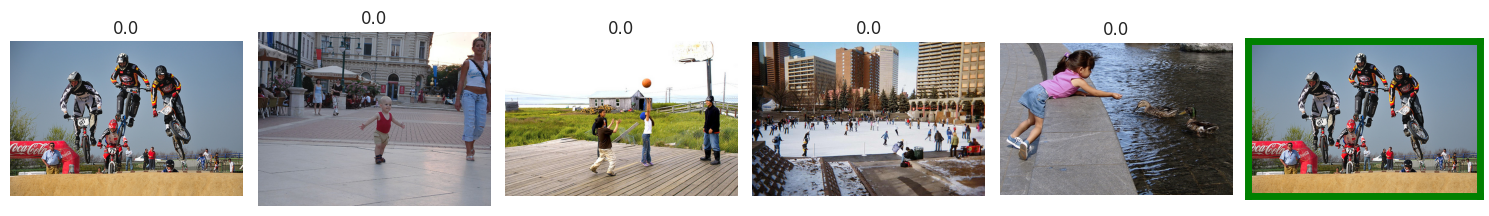

-------------------- a woman dumping water on a small child who is in a pool --------------------

This image is unavailable in your country in compliance with local laws.

-------------------- kids play ultimate Frisbee . --------------------

This image is unavailable in your country in compliance with local laws.

-------------------- Three children stand on or near a fence . --------------------

This image is unavailable in your country in compliance with local laws.

4/4 [==============================] - 0s 13ms/step

-------------------- a snowboarder wearing red is descending a snow covered mountain . --------------------



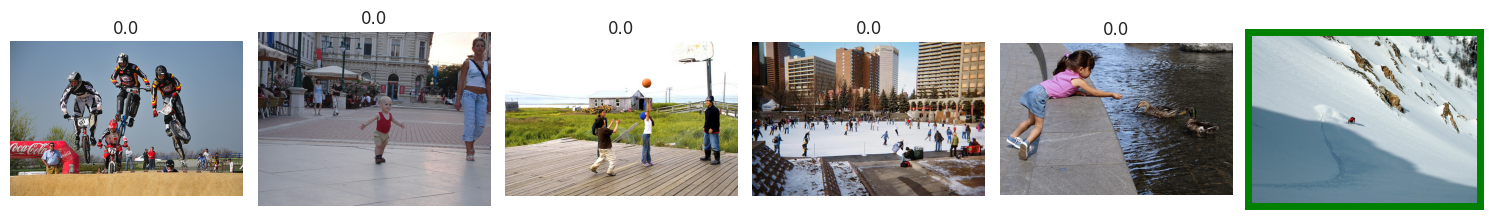

-------------------- kids are playing in water fountains --------------------

This image is unavailable in your country in compliance with local laws.

4/4 [==============================] - 0s 5ms/step

-------------------- The brown dog is wearing a black collar . --------------------



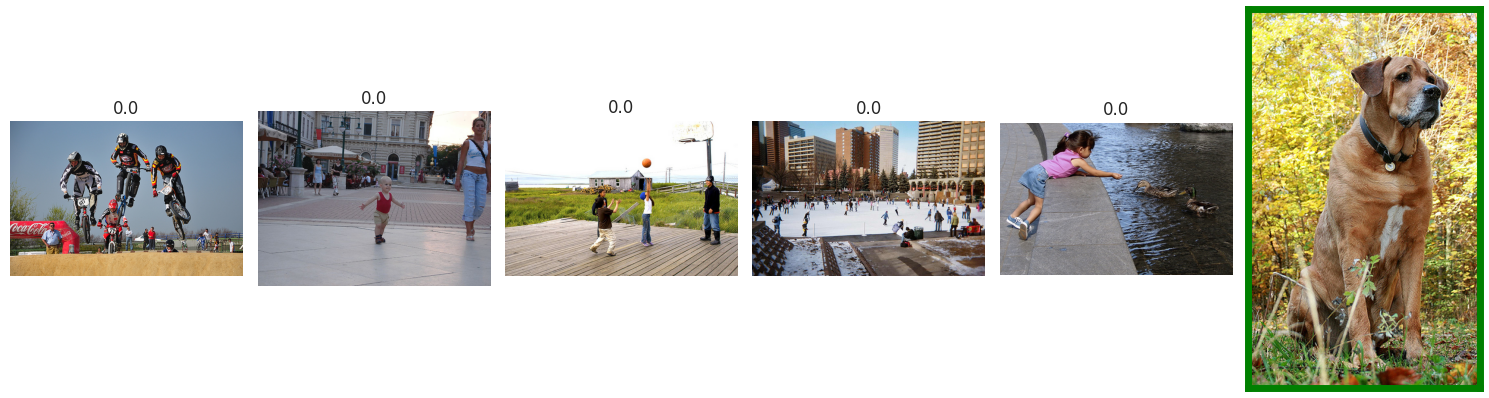

-------------------- The young boy flings mud at the barefoot girl in the pond . --------------------

This image is unavailable in your country in compliance with local laws.

-------------------- A man lies on a blue blanket with a child on his back . --------------------

This image is unavailable in your country in compliance with local laws.

4/4 [==============================] - 0s 9ms/step

-------------------- A man in a blue shirt lifts up his tennis racket and smiles . --------------------



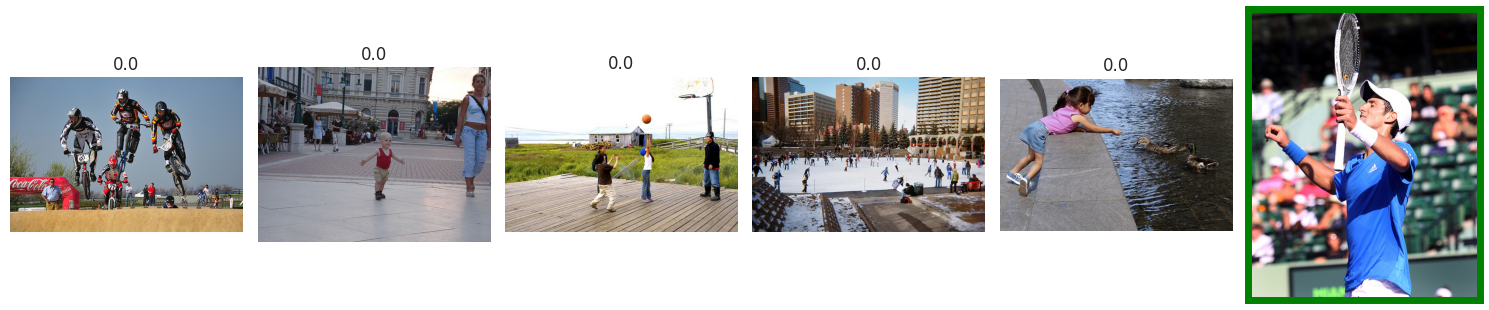

In [ ]:
for text in text_test:
    is_legal, message = check_legality(text)
    if not is_legal:
        print('-' * 20, text, '-' * 20)
        print('')
        print(message)
        print('')
        continue

    top, top_score = get_similar_images(text)

    print('')
    print('-' * 20, text, '-' * 20)
    print('')

    display_images(top, top_score, text)

In [ ]:
from torchvision.models import resnet50
from transformers import AutoTokenizer, AutoModel
from train_clip import CustomCLIPWrapper
import requests
from transformers import AutoProcessor, CLIPModel

In [ ]:
img_encoder = resnet50(pretrained=True)
img_encoder.fc = torch.nn.Linear(2048, 768)
tokenizer = AutoTokenizer.from_pretrained("johngiorgi/declutr-sci-base")
txt_encoder = AutoModel.from_pretrained("johngiorgi/declutr-sci-base")
model = CustomCLIPWrapper(img_encoder, txt_encoder, minibatch_size, avg_word_embs=True)

In [ ]:
python train.py --model_name RN50 --folder data_dir --batchsize 512

In [ ]:
model = CLIPModel.from_pretrained('/content')
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(
    text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True
)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)

## Заключение

В рамках этого проекта мы создали минимально работоспособную версию системы поиска изображений, основанную на фотографии. Для векторизации изображений мы использовали сеть ResNet50, а для текстовых эмбеддингов - BERT base cased EN.

Мы испытали модели для оценки схожести:

- LinearSVR
- Трёхслойная нейронная сеть

Однако, наилучшие результаты были получены с помощью трёхслойной нейронной сети.

В конце работы мы разработали функцию, которая на основе текстового запроса возвращает 5 наиболее похожих картинок. Эта функция была протестирована на наборе тестовых картинок.

Возможные пути для улучшения модели включают использование полного набора картинок из датасета Flickr30k и смену архитектуры решения.